import packages

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from get_all_followers import num_followers
from PullingDataFromSQL import get_followers_sql
import datetime

In [2]:
stream1, total_stream1 = get_followers_sql()

stream_series = num_followers(stream1)

In [3]:
stream1.head()

,index,followed_at,from_id,to_id
0,0,2018-01-20T19:08:38Z,158238266,56744242
1,1,2018-01-20T00:56:51Z,177314705,56744242
2,2,2018-01-19T20:19:39Z,191526768,56744242
3,3,2018-01-19T19:20:21Z,125102872,56744242
4,4,2018-01-19T19:10:12Z,191665382,56744242


resample series

In [4]:
weekly = stream_series.resample('W').sum()
weekly.head()

,follower_added
followed_at,
2014-04-20,6
2014-04-27,0
2014-05-04,0
2014-05-11,0
2014-05-18,0


Plot weekly followers added over lifetime of broadcaster

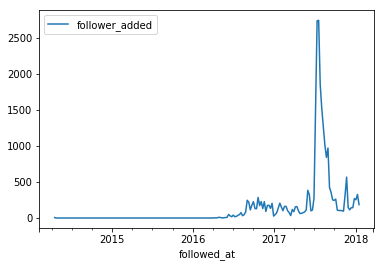

In [5]:
weekly.plot()

create 'y' and 'ds' columns for fb prophet

In [6]:
weekly['ds'] = weekly.index
weekly['y'] = weekly['follower_added']
weekly.head()

,follower_added,ds,y
followed_at,,,
2014-04-20,6,2014-04-20,6
2014-04-27,0,2014-04-27,0
2014-05-04,0,2014-05-04,0
2014-05-11,0,2014-05-11,0
2014-05-18,0,2014-05-18,0


just take the year 2017 as input 

In [7]:
min_date = datetime.datetime(2017,1,1)
max_date = datetime.datetime(2017,12,31)

In [8]:
data = weekly[(weekly.index > min_date) & (weekly.index < max_date)]
data = data[['ds', 'y']]
data[''] = range(0,len(data))
data = data.set_index('')
data['y'] = data['y'].apply(np.log)
data.tail()

,ds,y
,,
46,2017-11-26,6.342121
47,2017-12-03,4.990433
48,2017-12-10,4.727388
49,2017-12-17,4.969813
50,2017-12-24,4.969813


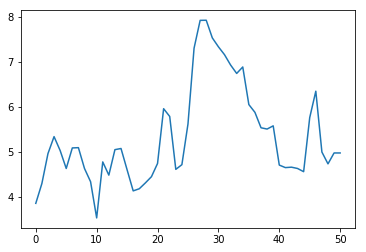

In [9]:
data['y'].plot()

make propeht object

In [16]:
forecast = Prophet(yearly_seasonality = True,weekly_seasonality=True, daily_seasonality=True)
forecast.fit(data)

In [21]:
future = forecast.make_future_dataframe(periods = 28)
stream_pred = forecast.predict(future)
stream_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
74,2018-01-17,6.042537,5.653412,6.422093
75,2018-01-18,6.099336,5.733172,6.482001
76,2018-01-19,6.151385,5.797422,6.507918
77,2018-01-20,6.198602,5.849389,6.569556
78,2018-01-21,6.527227,6.127627,6.875864


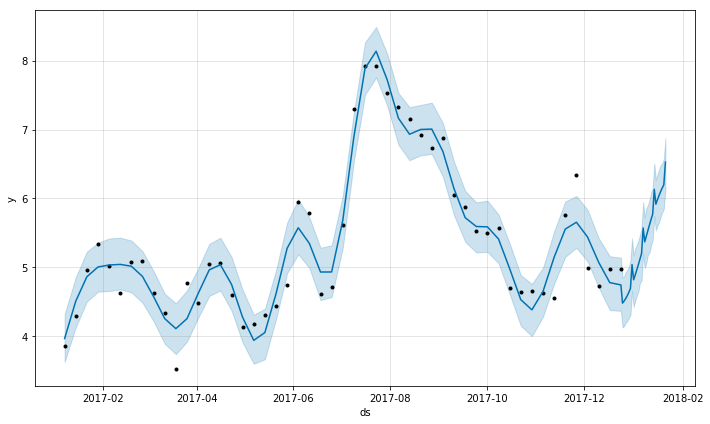

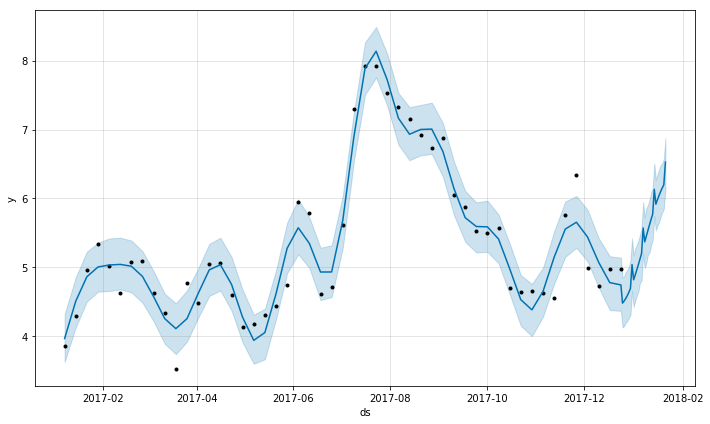

In [22]:
/forecast.plot(stream_pred)

In [20]:
weekly.tail()

,follower_added,ds,y
followed_at,,,
2017-12-24,144,2017-12-24,144
2017-12-31,270,2017-12-31,270
2018-01-07,254,2018-01-07,254
2018-01-14,328,2018-01-14,328
2018-01-21,186,2018-01-21,186


In [30]:
stream_pred[['ds','yhat', 'yhat_upper','yhat_lower']].iloc[51:78]

,ds,yhat,yhat_upper,yhat_lower
51,2017-12-25,4.479164,4.852959,4.125755
52,2017-12-26,4.508524,4.862804,4.147360
53,2017-12-27,4.544697,4.930960,4.192933
54,2017-12-28,4.587468,4.958328,4.219359
55,2017-12-29,4.636554,5.010110,4.264672
56,2017-12-30,4.691599,5.097072,4.304371
57,2017-12-31,5.038432,5.418546,4.657091
58,2018-01-01,4.817825,5.172408,4.423409
59,2018-01-02,4.887986,5.267195,4.512953
60,2018-01-03,4.962079,5.329692,4.590195


In [36]:
to_plot_pred = stream_pred[['ds','yhat', 'yhat_upper','yhat_lower']].iloc[51:78]

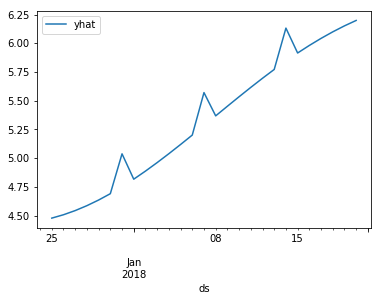

In [37]:
to_plot_pred.plot(x = 'ds', y = 'yhat')

In [44]:
to_plot_real = weekly.iloc[(len(weekly)-4):len(weekly), :].copy()
to_plot_real['y'] = to_plot_real['y'].apply(np.log)
to_plot_real

,follower_added,ds,y
followed_at,,,
2017-12-31,270,2017-12-31,5.598422
2018-01-07,254,2018-01-07,5.537334
2018-01-14,328,2018-01-14,5.793014
2018-01-21,186,2018-01-21,5.225747


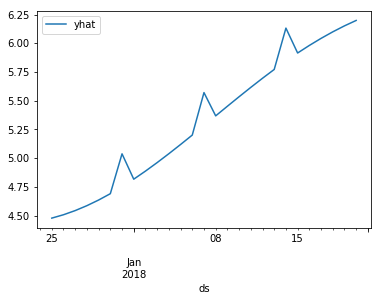

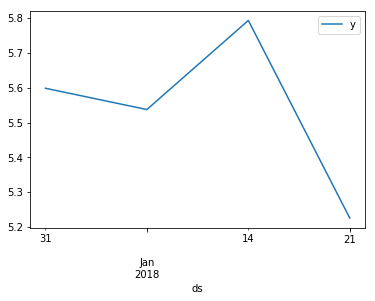

In [45]:
to_plot_pred.plot(x = 'ds', y = 'yhat')
to_plot_real.plot(x = 'ds', y = 'y')